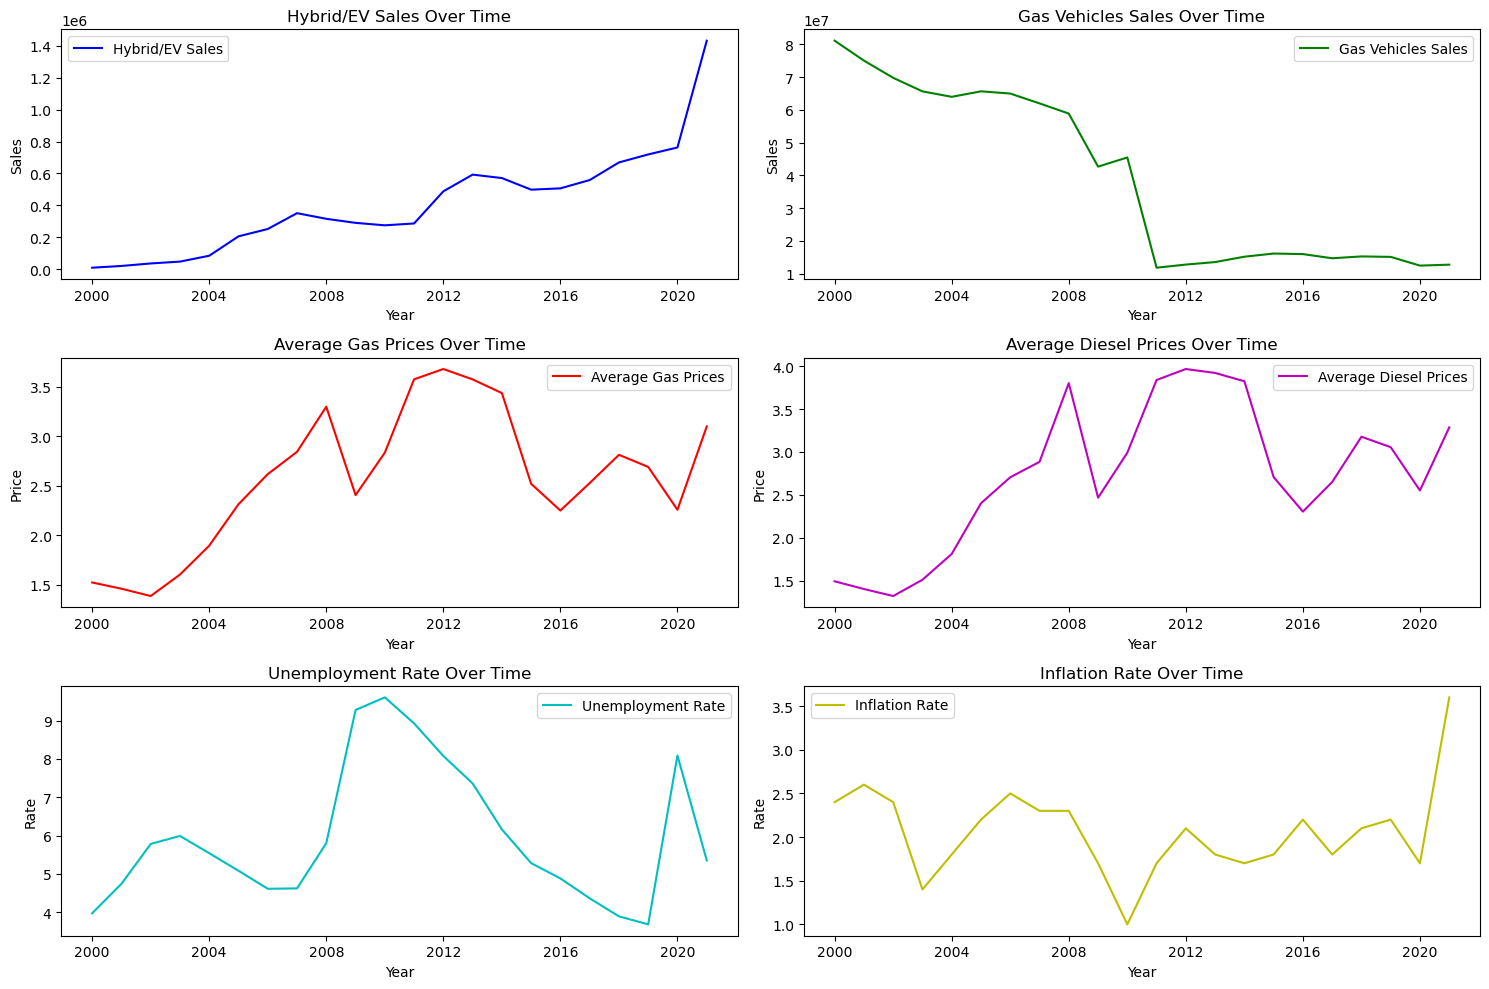

                       Average Gas Prices  Average Diesel Prices  \
Average Gas Prices               1.000000               0.992546   
Average Diesel Prices            0.992546               1.000000   
Unemployment Rate                0.359477               0.332424   
Inflation Rate                  -0.064891              -0.066973   
GDP Growth                       0.014405              -0.026230   
Hybrid/EV Sales                  0.532637               0.556203   
Gas Vehicles sales              -0.652465              -0.674813   

                       Unemployment Rate  Inflation Rate  GDP Growth  \
Average Gas Prices              0.359477       -0.064891    0.014405   
Average Diesel Prices           0.332424       -0.066973   -0.026230   
Unemployment Rate               1.000000       -0.538010   -0.478770   
Inflation Rate                 -0.538010        1.000000    0.369715   
GDP Growth                     -0.478770        0.369715    1.000000   
Hybrid/EV Sales        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'ML_DATASET.csv'
dataset = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format for better plotting
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y')

# Set the date column as the index
dataset.set_index('Date', inplace=True)

# Clean the 'Gas Vehicles sales' column by removing commas and converting to numeric
dataset['Gas Vehicles sales'] = dataset['Gas Vehicles sales'].str.replace(',', '').astype(float)

# Plotting trends over time
plt.figure(figsize=(15, 10))

# Subplot for Hybrid/EV Sales
plt.subplot(3, 2, 1)
plt.plot(dataset.index, dataset['Hybrid/EV Sales'], label='Hybrid/EV Sales', color='b')
plt.title('Hybrid/EV Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()

# Subplot for Gas Vehicle Sales
plt.subplot(3, 2, 2)
plt.plot(dataset.index, dataset['Gas Vehicles sales'], label='Gas Vehicles Sales', color='g')
plt.title('Gas Vehicles Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()

# Subplot for Average Gas Prices
plt.subplot(3, 2, 3)
plt.plot(dataset.index, dataset['Average Gas Prices'], label='Average Gas Prices', color='r')
plt.title('Average Gas Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Subplot for Average Diesel Prices
plt.subplot(3, 2, 4)
plt.plot(dataset.index, dataset['Average Diesel Prices'], label='Average Diesel Prices', color='m')
plt.title('Average Diesel Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Subplot for Unemployment Rate
plt.subplot(3, 2, 5)
plt.plot(dataset.index, dataset['Unemployment Rate'], label='Unemployment Rate', color='c')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()

# Subplot for Inflation Rate
plt.subplot(3, 2, 6)
plt.plot(dataset.index, dataset['Inflation Rate'], label='Inflation Rate', color='y')
plt.title('Inflation Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Display the correlation matrix
print(correlation_matrix)


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataset
file_path = 'ML_DATASET.csv'
dataset = pd.read_csv(file_path)

# Define the features and targets
features = ['Average Gas Prices', 'GDP Growth']
target_ev_sales = 'Hybrid/EV Sales'

# Prepare the feature and target datasets
X_ev = dataset[features]
y_ev = dataset[target_ev_sales]

# Fill missing values with the mean of the respective columns
X_ev.fillna(X_ev.mean(), inplace=True)
y_ev.fillna(y_ev.mean(), inplace=True)

# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_ev.columns
vif_data["VIF"] = [variance_inflation_factor(X_ev.values, i) for i in range(len(X_ev.columns))]
print(vif_data)

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_ev_poly = poly.fit_transform(X_ev)

# Normalize the features
scaler = StandardScaler()
X_ev_poly_scaled = scaler.fit_transform(X_ev_poly)

# Split the data into training and testing sets for EV sales prediction
X_ev_train, X_ev_test, y_ev_train, y_ev_test = train_test_split(X_ev_poly_scaled, y_ev, test_size=0.2, random_state=42)

# Define the models and hyperparameters for tuning
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

params = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

# Function to perform GridSearchCV and return the best model
def tune_model(model, params, X_train, y_train):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Tune and train the models for EV sales
best_rf_ev = tune_model(models['RandomForest'], params['RandomForest'], X_ev_train, y_ev_train)
best_gb_ev = tune_model(models['GradientBoosting'], params['GradientBoosting'], X_ev_train, y_ev_train)

# Create an ensemble of the best models
ensemble_model = VotingRegressor(estimators=[('rf', best_rf_ev), ('gb', best_gb_ev)])
ensemble_model.fit(X_ev_train, y_ev_train)

# Predict EV sales
y_ev_pred_ensemble = ensemble_model.predict(X_ev_test)

# Evaluate the ensemble model for EV sales
rmse_ensemble_ev = mean_squared_error(y_ev_test, y_ev_pred_ensemble, squared=False)
r2_ensemble_ev = r2_score(y_ev_test, y_ev_pred_ensemble)

results = {
    'EV Sales': {
        'RandomForest': {'RMSE': rmse_rf_ev, 'R2': r2_rf_ev},
        'GradientBoosting': {'RMSE': rmse_gb_ev, 'R2': r2_gb_ev},
        'Ensemble': {'RMSE': rmse_ensemble_ev, 'R2': r2_ensemble_ev}
    }
}

print(results)


C:\Users\gianf\AppData\Local\Temp\ipykernel_26156\3743477633.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ev.fillna(X_ev.mean(), inplace=True)


              feature       VIF
0  Average Gas Prices  2.180094
1          GDP Growth  2.180094
{'EV Sales': {'RandomForest': {'RMSE': 147802.02841079768, 'R2': 0.21453970073144035}, 'GradientBoosting': {'RMSE': 132758.21232363873, 'R2': 0.3662963018514459}, 'Ensemble': {'RMSE': 127687.64548745123, 'R2': 0.41377922164113967}}}


c:\Users\gianf\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


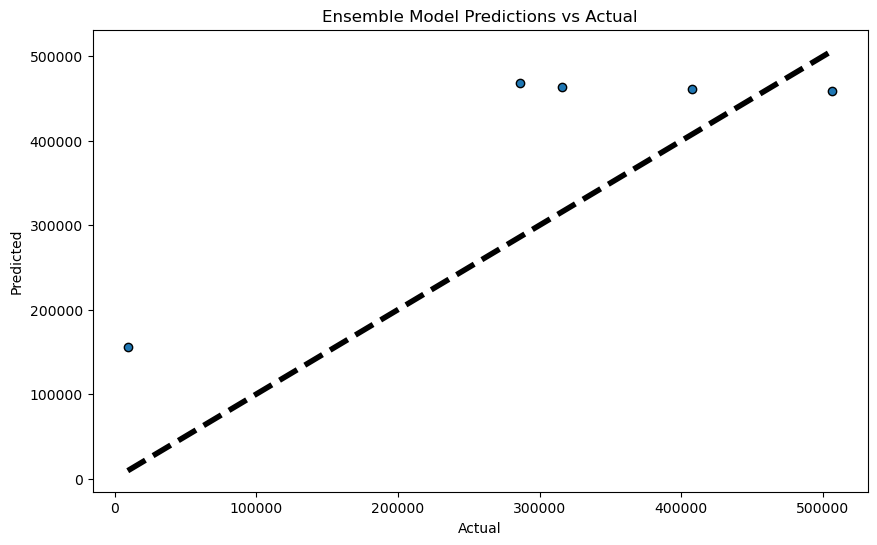

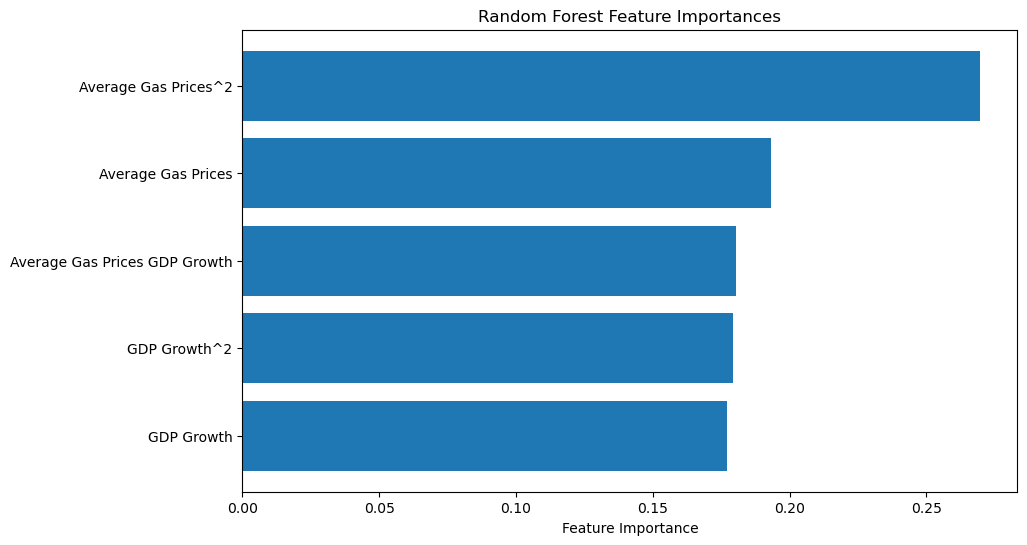

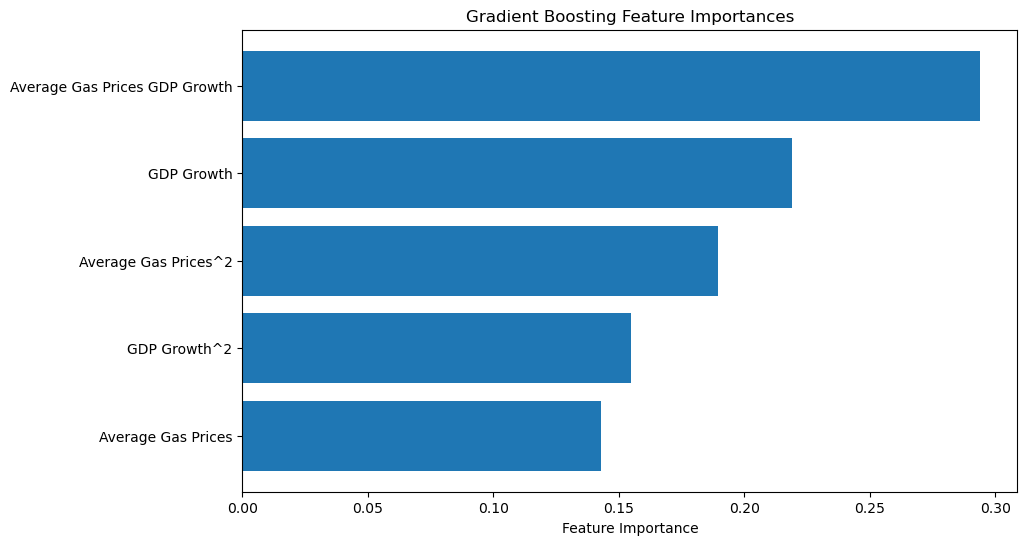

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot predictions vs actual values
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Plot predictions vs actual values for the ensemble model
plot_predictions(y_ev_test, y_ev_pred_ensemble, 'Ensemble Model Predictions vs Actual')

# Fit PolynomialFeatures on the training data
poly = PolynomialFeatures(degree=2, include_bias=False)
X_ev_poly = poly.fit_transform(X_ev)

# Create feature names for polynomial features
def create_poly_feature_names(features, poly):
    feature_names = poly.get_feature_names_out(features)
    return feature_names

# Create feature names for polynomial features
poly_feature_names = create_poly_feature_names(features, poly)

# Plot feature importances
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.show()

# Since the ensemble model is a VotingRegressor, we will plot feature importances of the individual models
plot_feature_importances(best_rf_ev, poly_feature_names, 'Random Forest Feature Importances')
plot_feature_importances(best_gb_ev, poly_feature_names, 'Gradient Boosting Feature Importances')
